# Artificial test set preparation

This notebook prepares the synthetic test set based on the Lakh MIDI Dataset (LMD). Run `../note_seq/prepare.ipynb` and `../audio_train/prepare.ipynb` first.

Copyright 2020 InterDigital R&D and Télécom Paris.  
Author: Ondřej Cífka

In [1]:
import collections
import concurrent.futures as cf
import copy
import glob
import hashlib
import itertools
import json
import os
import pickle
import random
import re
import shutil
import sys

import IPython.display as ipd
import librosa
from natsort import natsorted, ns
import note_seq
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import pysndfx
import soundfile as sf
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [2]:
INPUT_DIR = '../note_seq/data/'
INPUT_SECTION = 'test'  # 'val'
OUTPUT_SUFFIX = ''  # '_val'
OUTPUT_DIR = 'wav_16kHz' + OUTPUT_SUFFIX
TOTAL_FILES = 169556
SR = 16000
SF_PATH = '/data/ocifka/id_bkp/data/soundfonts/TimbresOfHeaven/Timbres Of Heaven (XGM) 3.94.sf2'

In [3]:
def filter_sequence(sequence, instrument_re=None, instrument_ids=None, programs=None, drums=None,
                    copy=False):
    if copy:
        sequence, original_sequence = note_seq.NoteSequence(), sequence
        sequence.CopyFrom(original_sequence)

    if isinstance(instrument_re, str):
        instrument_re = re.compile(instrument_re)

    # Filter the instruments based on name and ID
    deleted_ids = set()
    if instrument_re is not None:
        deleted_ids.update(i.instrument for i in sequence.instrument_infos
                           if not instrument_re.search(i.name))
    if instrument_ids is not None:
        deleted_ids.update(i.instrument for i in sequence.instrument_infos
                           if i.instrument not in instrument_ids)
    new_infos = [i for i in sequence.instrument_infos if i.instrument not in deleted_ids]
    del sequence.instrument_infos[:]
    sequence.instrument_infos.extend(new_infos)

    # Filter the event collections
    for collection in [sequence.notes, sequence.pitch_bends, sequence.control_changes]:
        collection_copy = list(collection)
        del collection[:]

        for event in collection_copy:
            if event.instrument in deleted_ids:
                continue
            if instrument_ids is not None and event.instrument not in instrument_ids:
                continue
            if programs is not None and event.program not in programs:
                continue
            if drums is not None and event.is_drum != drums:
                continue
            collection.add().CopyFrom(event)

    return sequence

In [4]:
def compute_stats(pm):
    piano_roll = ~np.isclose(pm.get_piano_roll(fs=100), 0)
    num_voices = piano_roll.sum(axis=0)
    pitches, _ = np.where(piano_roll)

    return {
        'voices': num_voices.sum() / ((num_voices > 0).sum() + 1e-9),
        'pitch.mean': np.mean(pitches),
        'pitch.low': np.percentile(pitches, 5),
        'pitch.high': np.percentile(pitches, 95),
        'program': instr.program
    }

In [5]:
with open('../audio_train/metadata.json') as f:
    src_metadata = json.load(f)[INPUT_SECTION]
    src_paths = [item['src_path'] for item in src_metadata.values()]

In [6]:
all_stats = collections.defaultdict(list)
for path in tqdm(src_paths):
    with open(os.path.join(INPUT_DIR, path), 'rb') as f:
        ns = pickle.load(f)
    pm = note_seq.midi_io.note_sequence_to_pretty_midi(ns)

    for instr in pm.instruments:
        if instr.is_drum:
            continue
        for k, v in compute_stats(instr).items():
            all_stats[k].append(v)

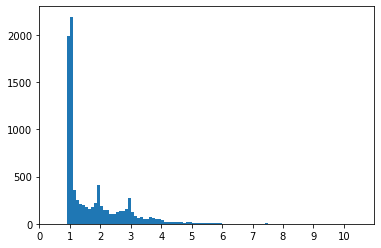

In [7]:
plt.hist(all_stats['voices'], bins=np.linspace(0.5, 10.5, 101))
plt.xticks(np.linspace(0, 10, 11))
plt.show()

In [8]:
np.median(all_stats['voices']), np.median(all_stats['pitch.mean'])

(1.1633061824006992, 62.81107256432495)

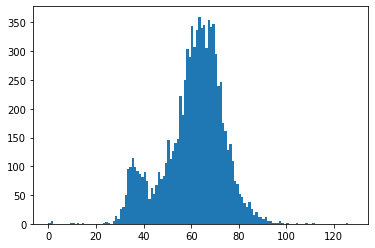

In [9]:
plt.hist(all_stats['pitch.mean'], bins=np.linspace(0, 128, 129))
plt.show()

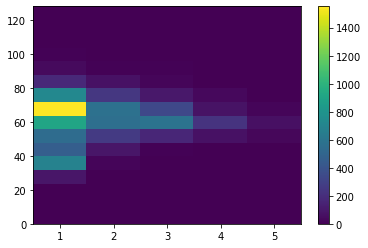

array([[   6,    4,    1,   85,  685,  456,  541,  913, 1552,  724,  171,
          42,    7,    2,    0,    0],
       [   0,    0,    0,    0,   23,   87,  261,  560,  573,  243,   68,
           7,    0,    1,    0,    0],
       [   0,    0,    0,    1,    1,   11,  165,  589,  334,   99,   20,
           8,    1,    0,    0,    0],
       [   0,    0,    0,    1,    4,    2,   70,  225,   75,   31,    2,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,   25,   64,   19,    5,    0,
           0,    0,    0,    0,    1]])

In [10]:
hist, _, _, _ = plt.hist2d(all_stats['voices'], all_stats['pitch.mean'], bins=[np.linspace(0.5, 5.5, 6), np.linspace(0, 128, 17)])
plt.colorbar()
plt.show()
hist.round().astype('int')

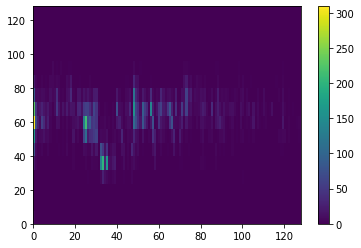

In [11]:
hist, _, _, _ = plt.hist2d(all_stats['program'], all_stats['pitch.mean'], bins=[np.linspace(0, 128, 129), np.linspace(0, 128, 17)])
plt.colorbar()
plt.show()

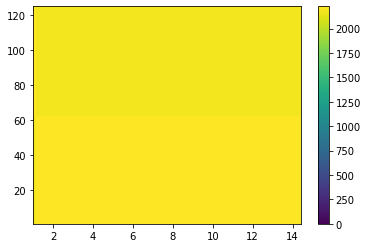

array([[2191, 2227],
       [2227, 2192]])

In [12]:
hist, _, _, _ = plt.hist2d(all_stats['voices'], all_stats['pitch.mean'],
                           bins=[np.quantile(all_stats['voices'], [0., 0.5, 1.]),
                                 np.quantile(all_stats['pitch.mean'], [0., 0.5, 1.])],
                           vmin=0)
plt.colorbar()
plt.show()
hist.round().astype('int')

In [13]:
voices_bins = np.quantile(all_stats['voices'], [0., 0.5, 1.])
pitch_bins = np.quantile(all_stats['pitch.mean'], [0., 0.5, 1.])

def assign_bin(a, bins):
    n = np.digitize(a, bins)
    return np.clip(n, a_min=1, a_max=len(bins) - 1)

binned = collections.defaultdict(list)
for path in tqdm(src_paths):
    with open(os.path.join(INPUT_DIR, path), 'rb') as f:
        ns_full = pickle.load(f)
    ns_full.filename = path
    if not ns_full.instrument_infos:
        continue
    max_instrument = max(ii.instrument for ii in ns_full.instrument_infos)

    for instrument, program in sorted(set((n.instrument, n.program) for n in ns_full.notes if not n.is_drum)):
        ns = filter_sequence(ns_full, instrument_ids={instrument}, copy=True)
        meta = {
            'src_path': path,
            'instrument': instrument,
            'src_program': program
        }

        stats = compute_stats(note_seq.midi_io.note_sequence_to_pretty_midi(ns))
        bin_key = 'voices{}_pitch{}'.format(assign_bin(stats['voices'], voices_bins),
                                            assign_bin(stats['pitch.mean'], pitch_bins))
        binned[bin_key].append((ns, meta))
binned = dict(binned)

In [14]:
def synth_ns(ns, out_path):
    audio = note_seq.midi_synth.fluidsynth(ns, sf2_path=SF_PATH, sample_rate=SR)
    if len(audio) < 1 * SR:  # Skip if shorter than 1 second
        return False
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    sf.write(out_path, audio, SR, subtype='PCM_24')
    return True

In [15]:
MAX_PER_PROGRAM = 4

metadata = {}
for bin_key in tqdm(sorted(binned.keys())):
    shuffled = np.random.default_rng(seed=0).choice(binned[bin_key], len(binned[bin_key]), replace=False)
    
    # Generate segments
    segments_by_program = collections.defaultdict(list)
    for ns, meta in shuffled:
        if len(segments_by_program[meta['src_program']]) >= MAX_PER_PROGRAM:
            continue

        # Use filename as seed
        seed = meta['src_path'].encode()
        seed = int.from_bytes(hashlib.sha512(seed).digest(), 'big')
        rng = np.random.default_rng(seed=seed)

        # Pick a non-silent segment
        boundaries = np.arange(0., ns.total_time, 1.)  # 1-second chunks
        onset_counts, _ = np.histogram([n.start_time for n in ns.notes], bins=boundaries)
        cumsum = np.cumsum(onset_counts > 0)
        [candidates] = np.nonzero(
            (onset_counts[:-7] > 0)  # The first second needs to have an onset
            & (cumsum[7:] - np.pad(cumsum[:-8], (1, 0)) >= 4))  # & at least 4 of 8 seconds need to have an onset
        if len(candidates) == 0:
            continue
        index = rng.choice(candidates)

        segment = note_seq.sequences_lib.extract_subsequence(ns, index, index + 8)
        segment_meta = {
            'src_path': meta['src_path'],
            'program': meta['src_program'],
            'instrument': meta['instrument'],
            'index': index
        }
        segments_by_program[meta['src_program']].append((segment, segment_meta))

    # Pair up segments so that we have two different programs in each pair. Synthesize audio.
    rng = np.random.default_rng(seed=0)
    with cf.ProcessPoolExecutor(16) as pool:
        futures = {}
        num_pairs = sum(len(x) for x in segments_by_program.values()) // 2
        for _ in range(num_pairs):
            avail_programs = [p for p, v in segments_by_program.items() if len(v) > 0]
            if len(avail_programs) < 2:
                break
            p1, p2 = rng.choice(avail_programs, 2, replace=False)
            (ns1, meta1), (ns2, meta2) = segments_by_program[p1].pop(), segments_by_program[p2].pop()

            # Create style transfer target (ground truth)
            ns3 = copy.deepcopy(ns1)
            for note in ns3.notes:
                note.program = meta2['program']

            meta = {
                'content': meta1,
                'style': meta2,
                'target': {
                    'src_path': meta1['src_path'],
                    'index': meta1['index'],
                    'program': meta2['program']
                }
            }
            digest = hashlib.md5(repr(meta).encode()).hexdigest()
            meta['content']['path'] = f'{bin_key}/{digest}.content.wav'
            meta['style']['path'] = f'{bin_key}/{digest}.style.wav'
            meta['target']['path'] = f'{bin_key}/{digest}.target.wav'
            assert digest not in metadata
            metadata[digest] = meta

            for ns, name in [(ns1, 'content'), (ns2, 'style'), (ns3, 'target')]:
                out_path = os.path.join(OUTPUT_DIR, meta[name]['path'])
                futures[pool.submit(synth_ns, ns, out_path)] = digest
        
        for future in tqdm(cf.as_completed(futures), total=len(futures), desc=bin_key):
            if not future.result():
                digest = futures[future]
                for name in metadata[digest]:
                    path = metadata[digest][name]['path']
                    if os.path.exists(path):
                        os.remove(path)
                del metadata[digest]

print(f'Saved {len(metadata)} triplets')



Saved 721 triplets


In [16]:
class NumPyJSONEncoder(json.JSONEncoder):
    def default(self, x):
        if isinstance(x, (np.ndarray, np.generic)):
            return x.tolist()
        else:
            return super().default(x)

In [17]:
with open(f'metadata{OUTPUT_SUFFIX}.json', 'w') as f:
    json.dump(metadata, f, cls=NumPyJSONEncoder)

In [18]:
with open(f'triplets{OUTPUT_SUFFIX}', 'w') as f:
    for _, meta in sorted(metadata.items()):
        print(os.path.join(OUTPUT_DIR, meta['content']['path']),
              os.path.join(OUTPUT_DIR, meta['style']['path']),
              os.path.join(OUTPUT_DIR, meta['target']['path']),
              sep='\t', file=f)

In [19]:
!cut -f 1,2 <triplets{OUTPUT_SUFFIX} >pairs{OUTPUT_SUFFIX}

In [20]:
!wc -l triplets* pairs*

   721 triplets
   721 pairs
  1442 total
